In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

## Load data file into dataframe

In [ ]:
# LOAD DATA FROM ALL FILES IN THE ROOT FOLDER. IF ONE FILE CONTAINS MULTIPLE SUBJECTS, THEN ALL OF THEM WILL BE LOADED.
root_path = "/Users/ajay/Downloads/imagenet_contrast_data/"
dfs = []
for fn in os.listdir(root_path):
	f = open(root_path + fn, "r")
	if fn.startswith("jatos") and fn.endswith(".txt"):
		lines = f.readlines()
		for l in lines:
			# write into temp file if valid
			if l.startswith('['):
				with open(root_path + "temp.txt", "w") as temp_file:
					temp_file.write(l)
			with open(root_path + "temp.txt", "r") as temp_file:
				dfs.append(pd.read_json(temp_file, orient='records'))

In [ ]:
print(len(dfs))

In [ ]:
dfs[0].head(10)

In [ ]:
count_asc = 0
for df in dfs:
	srid = df['url'][0]
	if df.iloc[500]['order'] == -1:
		print("{} Order: {}".format(srid, "D"))
	else:
		print("{} Order: {}".format(srid, "A"))
		count_asc += 1

print("---------\nTOTAL ASCENDING = {}, DESCENDING = {}".format(count_asc, len(dfs) - count_asc))

## Split data (after skipping first 10 from each) into training, motorTime, and time block dataframes

In [ ]:
# iterate through rows of df and store stim response record for each in appropriate block
def get_start_index(df, blockname):
	return df.loc[df['sender'] == "Screen" + blockname].index[0]

all_start_indices = []
for df in dfs:
	# get all start indices
	cat_idx = get_start_index(df, "CategorizationTutorial")
	# motortime_idx = get_start_index(df, "MotorTime")
	t0_idx = get_start_index(df, "0")
	t400_idx = get_start_index(df, "400")
	t600_idx = get_start_index(df, "600")
	t800_idx = get_start_index(df, "800")
	t1000_idx = get_start_index(df, "1000")
	# start_indices = [cat_idx, motortime_idx, t0_idx, t400_idx, t600_idx, t800_idx, t1000_idx]
	start_indices = [cat_idx, t0_idx, t400_idx, t600_idx, t800_idx, t1000_idx]

	all_start_indices.append(start_indices)
	print(df['url'][0], start_indices)


In [ ]:
# Store stimulus response data (after skipping first 10 rows) for each timed block
# blocks = ["cattut", "motortime", "0", "400", "600", "800", "1000"]
blocks = ["cattut", "0", "400", "600", "800", "1000"]
times = [500, 900, 1100, 1300, 1500]
blocked_datas = []

def get_sr_block_data(df, start_idx, n_samples, n_skip=0):
	block_df = df.iloc[start_idx:start_idx + n_samples + 1]
	return block_df[block_df["sender"] == "Stimulus & Response"][n_skip:]

for i, df in enumerate(dfs):
	blocked_data = {}

	for j, block in enumerate(blocks):
		if block == 'cattut':
			blocked_data[block] = get_sr_block_data(df, all_start_indices[i][j], 50*3)
		# elif block == "motortime":
		# 	blocked_data[block] = get_sr_block_data(df, start_indices[i], 16*3)
		else:
			block_df = get_sr_block_data(df, all_start_indices[i][j], 210*3, n_skip = 10)

			# eliminate data with impossible RTs
			block_df = block_df[block_df["duration"] <= times[j-1]+250]
			block_df = block_df[block_df["duration"] > 0]

			blocked_data[block] = block_df

	
	blocked_datas.append(blocked_data)


In [ ]:
blocked_datas[1]['0']['response']

In [ ]:
# Replace all NaN values with random category
categories = ["airplane", "bear", "bicycle", "bird", "boat", "bottle", 
"car", "cat", "chair", "clock", "dog", "elephant", "keyboard", "knife", "oven", "truck"]
for i, blocked_data in enumerate(blocked_datas):
	for j, block in enumerate(blocks[1:]):
		response_idx = blocked_data[block].columns.get_loc("response")
		b = blocked_data[block].values
		n = b[:, response_idx].astype(str) == 'nan'
		b[:, response_idx][n] = np.random.choice(categories, size=np.sum(n))
		blocked_datas[i][block] = pd.DataFrame(b, columns=blocked_data[block].columns)

In [ ]:
blocked_datas[1]['0']['response']

## Observe performance in Cat Tutorial

In [ ]:
cat_accs = []
for blocked_data, df in zip(blocked_datas, dfs):
	accuracy_cattut = blocked_data['cattut']['correct'][10:].sum() / len(blocked_data['cattut']['correct'][10:])
	cat_accs.append(accuracy_cattut * 100)
	print("{}: Accuracy on categorization tutorial: {} %".format(df['url'][0], accuracy_cattut * 100))

In [ ]:
cat_mean_times = []

for i, (blocked_data, df) in enumerate(zip(blocked_datas, dfs)):
	mean_rt_cattut = blocked_data['cattut']['duration'].mean()
	std_rt_cattut = blocked_data['cattut']['duration'].std()
	max_rt_cattut = blocked_data['cattut']['duration'].max()
	min_rt_cattut = blocked_data['cattut']['duration'].min()
	median_rt_cattut = blocked_data['cattut']['duration'].median()
	# print("RT on categorization tutorial:\nMean: {} ms\nSD: {} ms\nmax: {} ms\nmin: {} ms\nmedian: {}".format(mean_rt_cattut, std_rt_cattut, max_rt_cattut, min_rt_cattut, median_rt_cattut))
	print("{}: Mean RT: {}".format(df['url'][0], mean_rt_cattut))
	cat_mean_times.append(mean_rt_cattut)

## Accuracies and RTs in timed blocks

In [ ]:
throw_out = list(map(str,[
	2764,
	2791, 2804, 2806, 2808, 2816, 2832, 2838, 2843,
	2846, 2851, 2865, 2872, 2883, 2886, 2892, 2899, 2904, 2914, 2925
]))
for i, (blocked_data, df) in enumerate(zip(blocked_datas, dfs)):
	if df['url'][0]['srid'] in throw_out:
		continue
	plt.figure()

	accs = []
	mean_times = []
	for j, block in enumerate(blocks[1:]):
		acc = 100 * blocked_data[block]['correct'].sum() / len(blocked_data[block]['correct'])
		accs.append(acc)
		mean_times.append(np.mean(blocked_data[block]['duration']))

		plt.scatter(blocked_data[block]['duration'], [acc]*len(blocked_data[block]), label=block) # 200 + mt
		plt.axvline(times[j], color='k', linestyle='--')
		
	plt.plot(mean_times, accs, 'ko-')
	# plt.axhline(y=cat_accs[i], color='k', linestyle='--')
	plt.xlabel("Reaction time")
	plt.ylabel("Accuracy")
	# plt.yticks(range(0,110,10))
	plt.xticks(times)
	plt.title(df['url'][0])

In [ ]:
plt.figure()
for i, (blocked_data, df) in enumerate(zip(blocked_datas, dfs)):
	if df['url'][0]['srid'] in throw_out:
		continue

	accs = []
	mean_times = []
	for j, block in enumerate(blocks[1:]):
		acc = 100 * blocked_data[block]['correct'].sum() / len(blocked_data[block]['correct'])
		accs.append(acc)
		mean_times.append(np.mean(blocked_data[block]['duration']))

		# plt.scatter(blocked_data[block]['duration'], [acc]*len(blocked_data[block]), label=block) # 200 + mt
		plt.axvline(times[j], color='k', linestyle='--')
		
	plt.plot(mean_times, accs, 'ko-')
	# plt.axhline(y=cat_accs[i], color='k', linestyle='--')
	plt.xlabel("Reaction time")
	plt.ylabel("Accuracy")
	# plt.yticks(range(0,110,10))
	plt.xticks(times)
	plt.title(df['url'][0])

Text(0.5, 1.0, 'Descending')

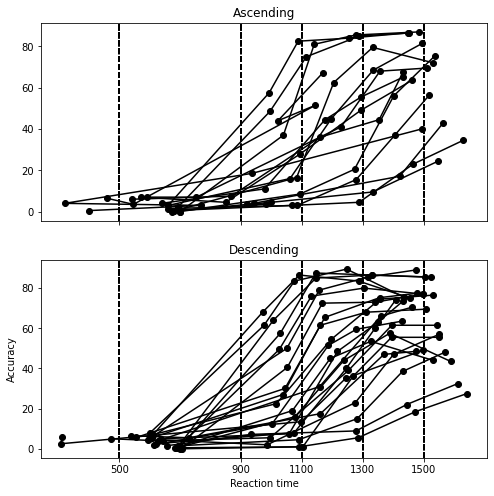

In [39]:
fig, axs = plt.subplots(2,1, figsize=(8,8), sharex=True)
for i, (blocked_data, df) in enumerate(zip(blocked_datas, dfs)):
	if df['url'][0]['srid'] in throw_out:
		continue

	if df.iloc[500]['order'] == 1.0:
		ax = axs[0]	
	elif df.iloc[500]['order'] == -1.0:
		ax = axs[1]
	else:
		raise ValueError("Order not 1 or -1")

	accs = []
	mean_times = []
	for j, block in enumerate(blocks[1:]):
		acc = 100 * blocked_data[block]['correct'].sum() / len(blocked_data[block]['correct'])
		accs.append(acc)
		mean_times.append(np.mean(blocked_data[block]['duration']))

		# plt.scatter(blocked_data[block]['duration'], [acc]*len(blocked_data[block]), label=block) # 200 + mt
		ax.axvline(times[j], color='k', linestyle='--')
		
	ax.plot(mean_times, accs, 'ko-')

# plt.axhline(y=cat_accs[i], color='k', linestyle='--')
plt.xlabel("Reaction time")
plt.ylabel("Accuracy")
# plt.yticks(range(0,110,10))
plt.xticks(times)
axs[0].set_title("Ascending")
axs[1].set_title("Descending")

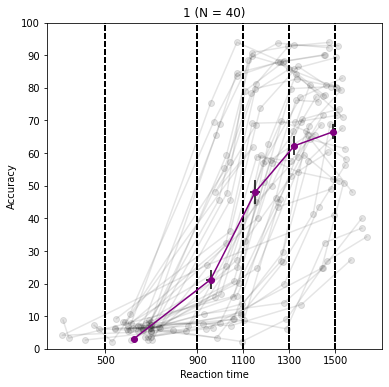

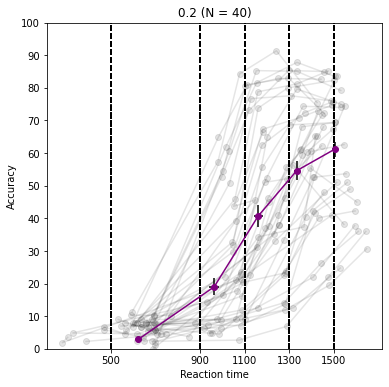

In [40]:
# PLOTTING MEAN SAT CURVE FOR MODES SEPARATELY
MODENAMES = ['1', '0.2']
for mode, mn in zip([1, 0.2], MODENAMES):
	all_accs = []
	all_mean_times = []
	for i, (blocked_data, df) in enumerate(zip(blocked_datas, dfs)):
		if df['url'][0]['srid'] in throw_out:
			continue

		accs = []
		mean_times = []
		for j, block in enumerate(blocks[1:]):
			mode_blocked_data = blocked_data[block].loc[blocked_data[block]['mode'] == mode]
			acc = 100 * mode_blocked_data['correct'].sum() / len(mode_blocked_data['correct'])
			accs.append(acc)
			mean_times.append(np.mean(mode_blocked_data['duration']))

		all_accs.append(accs)
		all_mean_times.append(mean_times)

	all_accs = np.array(all_accs)
	all_mean_times = np.array(all_mean_times)

	plt.figure(figsize=(6,6))
	# COPIED FROM PREVIOUS CELL WHICH PLOTS ALL OBSERVERS SEPARATELY
	for i, (blocked_data, df) in enumerate(zip(blocked_datas, dfs)):
		if df['url'][0]['srid'] in throw_out:
			continue

		accs = []
		mean_times = []
		for j, block in enumerate(blocks[1:]):
			mode_blocked_data = blocked_data[block].loc[blocked_data[block]['mode'] == mode]
			acc = 100 * (mode_blocked_data['category'] == mode_blocked_data['response']).mean()
			accs.append(acc)
			mean_times.append(np.mean(mode_blocked_data['duration']))

			# plt.scatter(blocked_data[block]['duration'], [acc]*len(blocked_data[block]), label=block) # 200 + mt
			plt.axvline(times[j], color='k', linestyle='--')
			
		plt.plot(mean_times, accs, 'ko-', alpha=0.1)
		# plt.axhline(y=cat_accs[i], color='k', linestyle='--')
		plt.xlabel("Reaction time")
		plt.ylabel("Accuracy")
		plt.yticks(range(0,110,10))
		plt.ylim([0,100])
		plt.xticks(times)
		plt.title(df['url'][0])

	plt.title("Average SAT for Mode '{}': N = {}".format(mode, len(dfs) - len(throw_out)))
	plt.title("{} (N = {})".format(mn.title(), len(dfs) - len(throw_out)))
	plt.errorbar(
		all_mean_times.mean(axis=0),
		all_accs.mean(axis=0),
		yerr=all_accs.std(axis=0)/np.sqrt(len(dfs)),
		xerr=all_mean_times.std(axis=0)/np.sqrt(len(dfs)),
		marker='o',
		linestyle = '-',
		color='purple',
		ecolor='k')
plt.show()

## 